In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output

2022-12-01 17:53:57.130372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 17:53:57.311876: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1201 17:53:57.403841710 3199160 ev_epoll1_linux.cc:121]     grpc epoll fd: 70
D1201 17:53:57.403880236 3199160 ev_posix.cc:141]            Using polling engine: epoll1
D1201 17:53:57.403917034 3199160 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1201 17:53:57.403926278 3199160 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1201 17:53:57.403935934 3199160 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1201 17:53:57

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-01 17:53:59.478631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 17:54:02.752878: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6b7aaa0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-01 17:54:02.752911: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-01 17:54:02.752919: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-01 17:54:02.752925: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-01 17:54:02.752931: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 64
img_height = 240
img_width = 240
data_dir = os.path.join('data','UPENN-GBM','slice_classification_common_stratify','train')


In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 39780 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 49725 files belonging to 5 classes.
Using 9945 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [9]:
 # Calculate class weights ofr weighting accuracy
ds_classes = []
for _, batch_classes in train_ds:
    ds_classes.append(batch_classes.numpy())

ds_classes = np.concatenate(ds_classes)

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(ds_classes),
    y=ds_classes
)

class_weight = dict(zip(np.unique(ds_classes), class_weight))


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [12]:
num_classes = len(class_names)

In [13]:
margin = 8
scaled_height = img_height - 2*margin
scaled_width = img_width - 2*margin

In [14]:
# Load saved model
with strategy.scope():
    trained_down_model = tf.keras.models.load_model('models/mobilenetv2_bs64_pat10_del0.001_dr0.25_lr0.0005_save-2022-12-01-14:58:29')


2022-12-01 17:54:25.525354: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-01 17:54:25.587786: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [15]:
val_test_batch_ims, val_test_batch_true_classes = next(iter(val_ds))

2022-12-01 17:54:45.623771: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:
val_preds = trained_down_model.predict(val_test_batch_ims)

2022-12-01 17:54:47.624908: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:8031540477718905018
2022-12-01 17:54:47.735480: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-01 17:54:47.855758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-01 17:54:48.113541: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(8229396767967817965), session_name()


2/2 [==============================] - 6s 14ms/step


2022-12-01 17:54:51.808008: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 8229396767967817965 with session name  took 3.694388565s and succeeded
2022-12-01 17:54:51.821817: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(8229396767967817965), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_8031540477718905018", property.function_library_fingerprint = 1972093359587801283, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-01 17:54:51.821882: I tensorflow/core/tpu/kernels/

In [17]:
from sklearn.metrics import classification_report
val_test_probs = tf.nn.softmax(val_preds)
val_pred_class = [np.argmax(x) for x in val_test_probs]
print(classification_report(val_test_batch_true_classes, val_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11
           2       0.00      0.00      0.00         1
           3       1.00      1.00      1.00         1
           4       0.97      0.95      0.96        37

    accuracy                           0.95        64
   macro avg       0.79      0.79      0.79        64
weighted avg       0.97      0.95      0.96        64



In [18]:
with strategy.scope():
    # Use the activations of these layers
    pretrained_layer_name='mobilenetv2_1.00_224'
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]
    base_model_outputs = [
        trained_down_model.get_layer(pretrained_layer_name)
        .get_layer(name).output for name in layer_names
    ]

    # Create the feature extraction model
    down_stack = tf.keras.Model(
        inputs=trained_down_model.get_layer(pretrained_layer_name).input, 
        outputs=base_model_outputs
    )

    down_stack.trainable = False

In [19]:
down_stack.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [20]:
tf.keras.utils.plot_model(down_stack, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:

# Define each layer block for upbranch
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.

  Conv2DTranspose => Batchnorm => Dropout => Relu

  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer

  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  #elif norm_type.lower() == 'instancenorm':
  #  result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [22]:
up_stack = [
    upsample(512, 3),  # 7x7 -> 14x14
    upsample(256, 3),  # 14x14 -> 28x28
    upsample(128, 3),  # 28x28 -> 56x56
    upsample(64, 3),   # 56x56 -> 112x112
]

In [23]:
for layer in trained_down_model.layers[1:4]:
    print(layer.name)

cropping2d
rescaling
conv2d


In [24]:
def unet_model(output_channels: int):

    # Add layers from classification model
    inputs = tf.keras.layers.Input(shape=[240, 240, 4])
    x = trained_down_model.layers[1](inputs)
    for layer in trained_down_model.layers[2:4]:
        x = layer(x)

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last_conv_trans = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2, padding="same"
    )  # 64x64 -> 128x128

    x = last_conv_trans(x)

    x = tf.keras.layers.ZeroPadding2D(8)(x)

    return tf.keras.Model(inputs=inputs, outputs=x)


In [25]:
OUTPUT_CLASSES = 4
with strategy.scope():
    model = unet_model(output_channels=OUTPUT_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']
    )

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 cropping2d (Cropping2D)        (None, 224, 224, 4)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 4)  0           ['cropping2d[1][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 3)  15          ['rescaling[1][0]']        

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [29]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify','train','map_data')

pixel_counts = [0,0,0,0]

for image_file in os.listdir(train_image_dir):
    map_file = image_file.replace('allseq', 'map')
    if not os.path.exists(os.path.join(train_map_dir,map_file)):
        raise FileNotFoundError((image_file, map_file))

    image = tf.io.read_file(os.path.join(train_image_dir,image_file))
    image = tf.io.decode_png(image, channels=4)
    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)
    
    # Convert map to make class integers contiguous
    seg_map = seg_map.numpy()
    seg_map[seg_map==4] = 3
    seg_map = tf.convert_to_tensor(seg_map)
    
    # Count pixel classes
    indices,counts = np.unique(seg_map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
    
    images.append(image)
    maps.append(seg_map)

In [30]:
train_images, val_images, train_maps, val_maps = train_test_split(images, maps, test_size=0.2)
train_images = tf.convert_to_tensor(train_images)
train_maps = tf.convert_to_tensor(train_maps)
val_images = tf.convert_to_tensor(val_images)
val_maps = tf.convert_to_tensor(val_maps)

In [31]:
train_images.shape, val_images.shape

(TensorShape([68076, 240, 240, 4]), TensorShape([17019, 240, 240, 4]))

In [32]:
pixel_counts

[4855852310, 6097015, 29626584, 9896091]

In [33]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def create_dataset(img, seg_map, scaler):
    img = scaler(tf.cast(img, tf.float32))
    
    return img,seg_map

In [34]:
train_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(train_images,train_maps,scaler_neg1_1)
)
val_data = tf.data.Dataset.from_tensor_slices(
    create_dataset(val_images,val_maps,scaler_neg1_1)
)

2022-12-01 17:58:42.734068: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.
2022-12-01 17:58:46.945445: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.
2022-12-01 17:58:52.150946: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.


In [35]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [36]:
train_batch = (
    train_data.cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [37]:
val_batch = val_data.batch(BATCH_SIZE)

2022-12-01 17:59:10.123510: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 62738841600 exceeds 10% of free system memory.


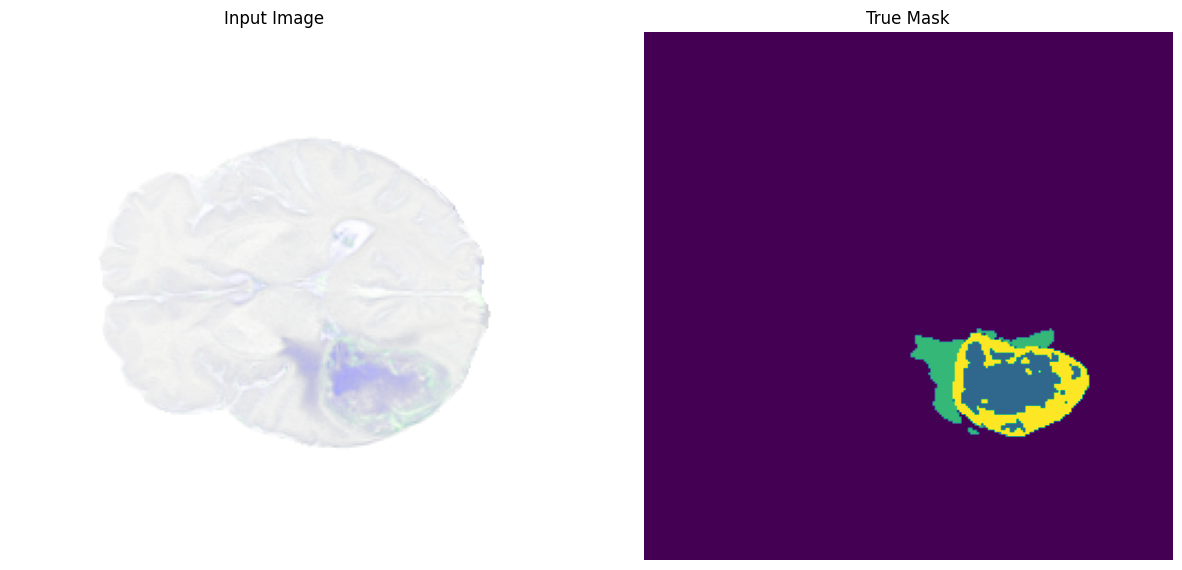

(64, 240, 240, 4) (64, 240, 240, 1)


2022-12-01 18:00:23.497374: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [38]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

2022-12-01 18:00:25.845708: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:10514671876647327548
2022-12-01 18:00:26.090739: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-01 18:00:26.413905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-01 18:00:26.960975: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(10335718403597078183), session_name()


1/1 [==============================] - 7s 7s/step


2022-12-01 18:00:30.827720: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 10335718403597078183 with session name  took 3.866649874s and succeeded
2022-12-01 18:00:30.840816: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(10335718403597078183), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_10514671876647327548", property.function_library_fingerprint = 12633604646081797117, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-01 18:00:30.840878: I tensorflow/

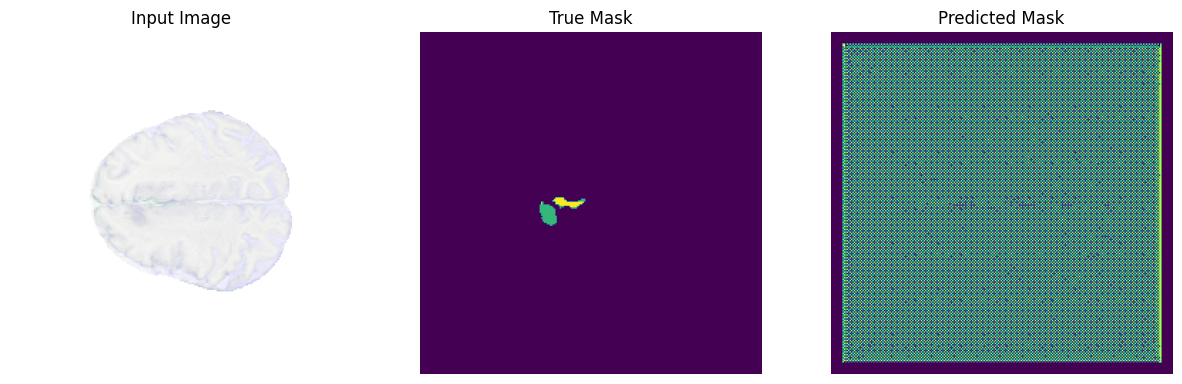

In [39]:
slice_num=21
sample_image, sample_mask = images[slice_num], masks[slice_num]
show_predictions()

In [40]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [41]:
# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [42]:
weights

array([0.0006887 , 0.5484999 , 0.11287876, 0.33793264])

In [43]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            )

1/1 [==============================] - 0s 435ms/step


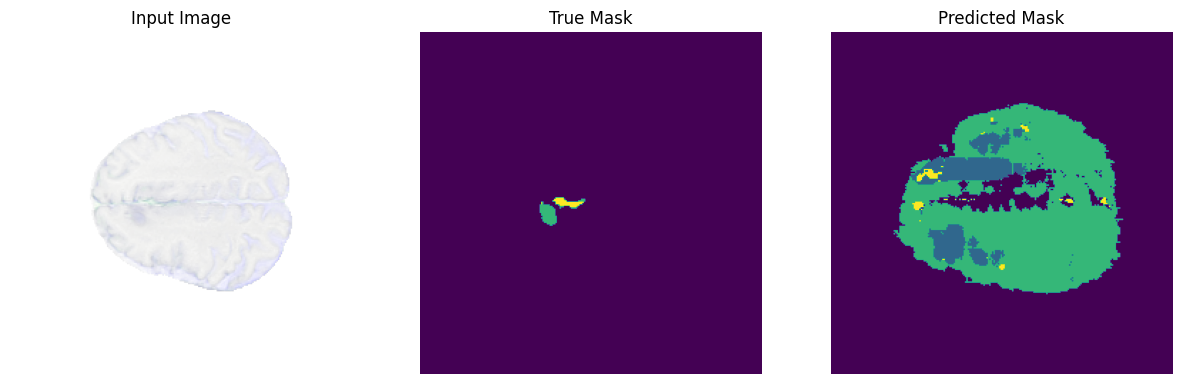


Sample Prediction after epoch 7

1063/1063 [==============================] - 121s 114ms/step - loss: 0.0018 - accuracy: 0.8524 - val_loss: 1.0062 - val_accuracy: 0.7808


In [45]:
#lr 0.0001
TRAIN_LENGTH=68076
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 17019//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [88]:
num = 17
single_img = tf.expand_dims(val_images[num],0)
single_map = tf.expand_dims(val_maps[num],0)
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


1/1 [==============================] - 0s 460ms/step


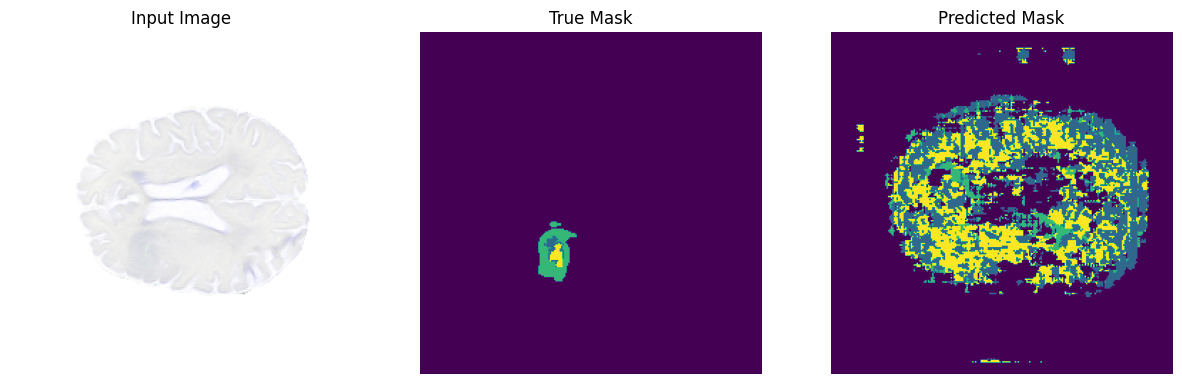

In [89]:
show_predictions(single_ds)

In [90]:
# Fully relax model
model.trainable = True

with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    

1/1 [==============================] - 0s 428ms/step


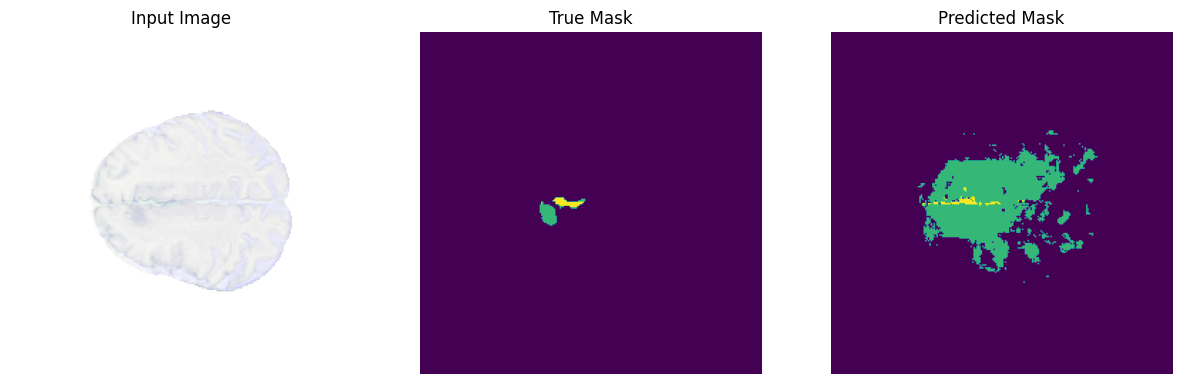


Sample Prediction after epoch 15

1063/1063 [==============================] - 135s 127ms/step - loss: 9.5703e-04 - accuracy: 0.9561 - val_loss: 0.2630 - val_accuracy: 0.9682


In [91]:
model_history_fullrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

2022-12-01 18:58:36.263186: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:5098080606980869531
2022-12-01 18:58:36.411707: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-01 18:58:36.613277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 2s 2s/step


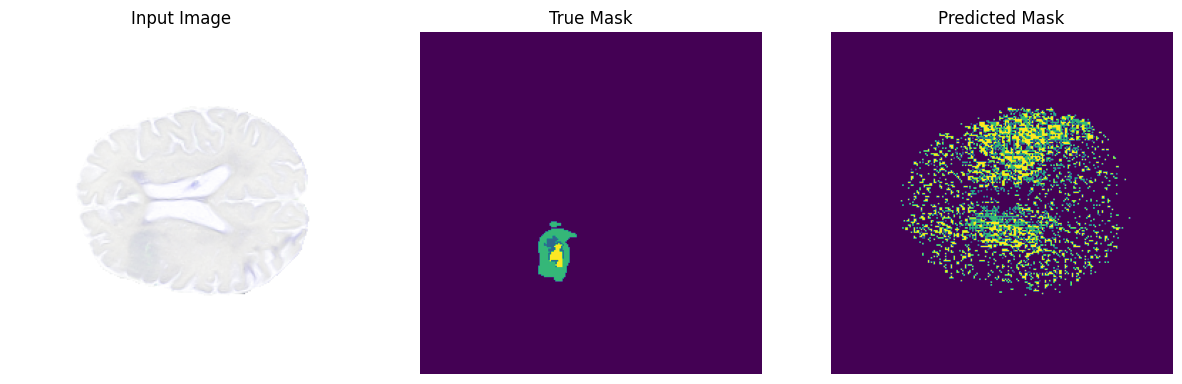

In [92]:
show_predictions(single_ds)